In [11]:
library(vita)
library(stringr)
library(doParallel)
library(randomForest)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


In [3]:
data <- read.csv('../data/amelia_data.csv', sep='\t')

head(data)

timestamp,VAL_23.FT.92512.X.Value.average,VAL_23.FT.92521.X.Value.average,VAL_23.FT.92537.01.X.Value.average,VAL_23.FT.96151.X.Value.average,VAL_23.FT.96152.X.Value.average,VAL_23.FT.96158.X.Value.average,VAL_23.FT.96159.X.Value.average,VAL_23.KA.9101.M01.62B.X.Value.average,VAL_23.KA.9101_APE.VALUE.average,⋯,VAL_45.PDT.92506.X.Value.average,VAL_45.PDT.92606.X.Value.average,VAL_45.PT.92508.X.Value.average,VAL_45.PT.92608.X.Value.average,VAL_45.PT.92609.X.Value.average,VAL_45.TT.92506.X.Value.average,VAL_45.TT.92508.X.Value.average,VAL_45.TT.92606.X.Value.average,VAL_45.TT.92607A.X.Value.average,VAL_45.TT.92607B.X.Value.average
1.514765e+12,86513.12,4.401998,161173.2,17.38066,27.70608,18.39865,19.40636,9141.690,85.09909,⋯,0.5493244,0.4843041,2.275901,3.702201,3.726124,16.27771,46.15202,16.82067,108.5209,60.94572
1.514765e+12,95862.07,4.456219,164465.8,17.39795,27.79270,18.39151,19.42285,9252.934,83.62878,⋯,0.5509349,0.4832682,2.273809,3.685665,3.711056,16.27945,46.14248,16.76080,108.5977,60.81935
1.514765e+12,96191.59,4.505277,166973.2,17.40821,27.78446,18.38340,19.41854,9404.077,83.79804,⋯,0.5502207,0.4796795,2.273511,3.679600,3.704178,16.28329,46.09172,16.80574,108.7205,60.75282
1.514765e+12,91128.62,4.499127,164402.7,17.42042,27.78758,18.41191,19.42989,9264.223,83.78863,⋯,0.5509333,0.4816260,2.273505,3.666550,3.693027,16.28191,46.12929,16.86113,108.9298,60.78318
1.514765e+12,91532.35,4.507830,164649.2,17.39303,27.71386,18.39100,19.39947,9310.935,84.02951,⋯,0.5513894,0.4820547,2.276424,3.714492,3.740088,16.27711,46.24554,16.83897,109.0733,60.85556
1.514765e+12,88252.00,4.523839,164766.4,17.41381,27.74474,18.39843,19.41493,9275.117,83.54444,⋯,0.5508509,0.4865489,2.275578,3.707182,3.732400,16.29041,46.33954,16.85636,109.1350,60.95016


In [4]:
percentage_na <- round(sum(is.na(data)) / nrow(data),2)
cat(str_glue('Percentage NAs: {percentage_na}%'), '\n')
cat(str_glue('Number of rows in data: {nrow(data)}'),'\n')
cat(str_glue('Number of cols in data: {ncol(data)}'),'\n')

Percentage NAs: 0% 
Number of rows in data: 8464 
Number of cols in data: 118 


In [6]:
y <- data[['VAL_23.FT.92537.01.X.Value.average']]
X <- within(data, rm('VAL_23.FT.92537.01.X.Value.average', 'timestamp'))

In [9]:
cl <- makeCluster(6)
registerDoParallel(cl)

In [14]:
vari <- compVarImp(
    X = X,
    y = y,
    rForest = foreach(ntree=rep(10, 6), .combine=combine, .multicombine=TRUE,
              .packages='randomForest') %dopar% {
    randomForest(X, y, ntree = 500, importance = TRUE, keep.inbag = TRUE)
    }
)

In [36]:
varimp_sorted <- as.data.frame(vari$importance[order(vari$importance, decreasing = T),])
colnames(varimp_sorted) <- c('mean dec. mse')
head(varimp_sorted, 10)

,mean dec. mse
VAL_23_FT_92537_03.Z.X.Value.average,5578545.36
VAL_23.KA.9101.M01.62B.X.Value.average,892537.80
VAL_23_PIC_92538_06.Z.X.Value.average,621070.90
VAL_23_KA_9101_M01_62C.Z.X.Value.average,606461.45
VAL_23_FT_92537_02.Z.X.Value.average,362367.92
VAL_23.PDT.92530.X.Value.average,196875.79
VAL_23.PDT.92534.X.Value.average,189002.34
VAL_23.PDT.92602.X.Value.average,51584.38
VAL_23_FIC_92543_04.Z.X.Value.average,26066.76
VAL_23.PT.92523.X.Value.average,12662.88


In [16]:
parallel::stopCluster(cl)

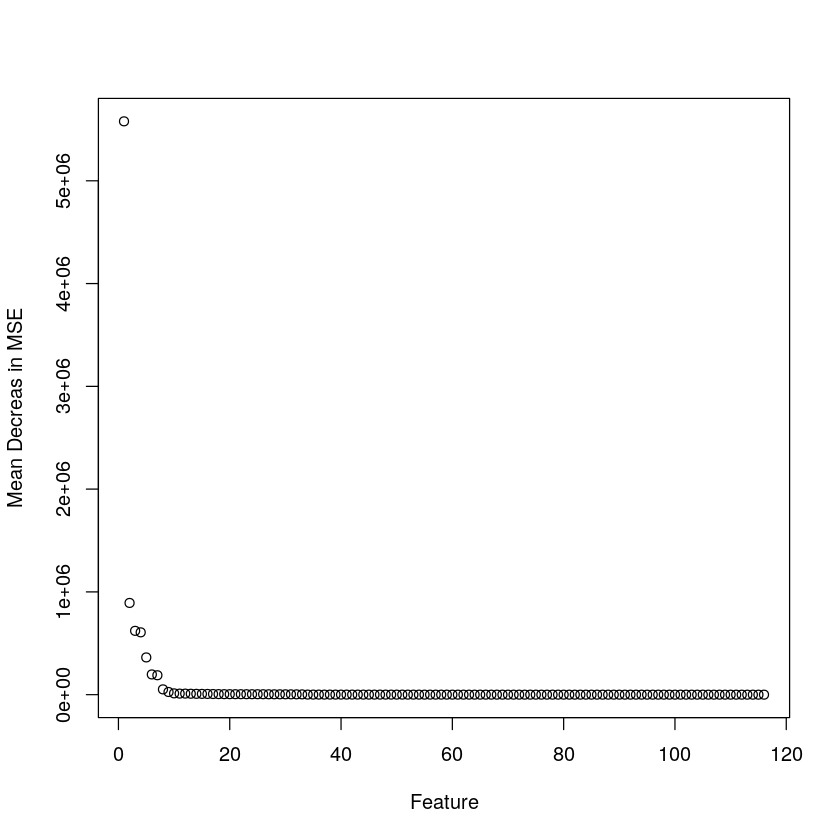

In [34]:
plot(1:nrow(varimp.sorted), varimp.sorted[['mean dec. mse']], xlab='Feature', ylab='Mean Decreas in MSE') 